In [1]:
seed= 1

In [2]:
from nasbench import api

nasbench_path = '../data/nasbench_only108.tfrecord'
nb = api.NASBench(nasbench_path)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 33 seconds


In [3]:
import glob
import os

train_pretrained = glob.glob('../../../pretrained_nets/hashes/train_hashes_100_splits/out_?/')
train_pretrained += glob.glob('../../../pretrained_nets/hashes/train_hashes_100_splits/out_??/')

val_pretrained = glob.glob('../../../pretrained_nets/hashes/valid_hashes_60_splits/out_?/')
val_pretrained += glob.glob('../../../pretrained_nets/hashes/valid_hashes_60_splits/out_??/')
val_pretrained

['../../../pretrained_nets/hashes/valid_hashes_60_splits/out_0/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_1/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_2/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_3/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_4/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_5/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_6/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_7/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_8/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_9/',
 '../../../pretrained_nets/hashes/valid_hashes_60_splits/out_10/']

In [4]:
import torch
from info_nas.datasets.arch2vec_dataset import get_labeled_unlabeled_datasets

#torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# device = None otherwise the dataset is save to the cuda as a whole
labeled, unlabeled = get_labeled_unlabeled_datasets(nb, device=device, seed=seed,
                                                    train_pretrained=train_pretrained,
                                                    valid_pretrained=val_pretrained,
                                                    train_labeled_path='../data/train_long.pt',
                                                    valid_labeled_path='../data/valid_long.pt')

Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Processing labeled nets for the training set...
Loading labeled dataset from ../data/train_long.pt.
Processing labeled nets for the validation set...
Loading labeled dataset from ../data/valid_long.pt.


In [25]:
print(labeled['train'].keys())
labeled['train']['net_hashes']

dict_keys(['net_hashes', 'inputs', 'outputs', 'dataset', 'labels', 'use_reference', 'net_repo'])


array(['4a6771dd03839135f5162c8a37ca2f5c',
       '4a6771dd03839135f5162c8a37ca2f5c',
       '4a6771dd03839135f5162c8a37ca2f5c', ...,
       'ddf217820b05230fda257d4d9b504f9e',
       'ddf217820b05230fda257d4d9b504f9e',
       'ddf217820b05230fda257d4d9b504f9e'], dtype='<U32')

In [35]:
from info_nas.datasets.io.transforms import SortByWeights

include_bias = True
sorter = SortByWeights(include_bias=include_bias, fixed_label=None)

In [36]:
from info_nas.datasets.io.semi_dataset import labeled_network_dataset

train_dataset = labeled_network_dataset(labeled['train'], transforms=sorter,
                                        return_hash=True, return_ref_id=True)
train_dataset.get_batch_names()

['adj', 'ops', 'input', 'output', 'label', 'weights', 'bias', 'hash', 'ref_id']

In [22]:
for b in train_dataset:
    print(b.keys())
    break
b['ref_id']

dict_keys(['adj', 'ops', 'input', 'output', 'label', 'weights', 'bias', 'hash', 'ref_id'])


tensor(0)

In [37]:
import numpy as np


outputs = []
labels = []
hashes = []
ref_ids = []

print(len(train_dataset))
for i, b in enumerate(train_dataset):
    if i % 50000 == 0:
        print(i)
    
    outputs.append(b['output'])
    labels.append(b['label'])
    hashes.append(b['hash'])
    ref_ids.append(b['ref_id'])
    
outputs = np.array([o.cpu().numpy() for o in outputs])
labels = np.array(labels)
hashes = np.array(hashes)
ref_ids = np.array(ref_ids)

608000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000


In [9]:
# compare


In [10]:
from info_nas.datasets.io.transforms import SortByWeights

include_bias = True
sorter2 = SortByWeights(include_bias=include_bias, fixed_label=2)

In [11]:
sorter2.fixed_label

2

In [26]:
from info_nas.datasets.io.semi_dataset import labeled_network_dataset

train_dataset2 = labeled_network_dataset(labeled['train'], transforms=sorter2,
                                         return_hash=True, return_ref_id=True)
train_dataset2.get_batch_names()

['adj', 'ops', 'input', 'output', 'label', 'weights', 'bias', 'hash', 'ref_id']

In [27]:
import numpy as np


outputs2 = []
labels2 = []
hashes2 = []
ref_ids = []

print(len(train_dataset2))
for i, b in enumerate(train_dataset2):
    if i % 50000 == 0:
        print(i)
    
    outputs2.append(b['output'])
    labels2.append(b['label'])
    hashes2.append(b['hash'])
    
outputs2 = np.array([o.cpu().numpy() for o in outputs2])
labels2 = np.array(labels2)
hashes2 = np.array(hashes2)

608000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000


In [14]:
# compare end

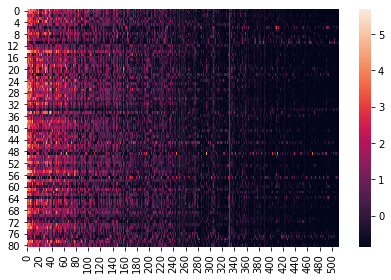

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

label = 0

hashmap = hashes == hashes[1]
labelmap = labels == label
#omap = labelmap
omap = np.logical_and(hashmap, labelmap)

letadlo = outputs[omap][:]
lmax = letadlo.max()

lmean = letadlo.mean()
lstd = letadlo.std()

plt.figure()
#sns.heatmap(letadlo / lmax)
sns.heatmap((letadlo - lmean)/ lstd)
plt.tight_layout()
plt.savefig(f"heatmap_all-net_{0}-data-label_{label}.png")
plt.show()
plt.close()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

label = 2

hashmap = hashes2 == hashes2[1]
labelmap = labels2 == label
#omap = labelmap
omap = np.logical_and(hashmap, labelmap)

letadlo = outputs2[omap][:]
lmax = letadlo.max()

plt.figure()
sns.heatmap(letadlo / lmax)
plt.tight_layout()
plt.savefig(f"heatmap_all-net_{0}-data-label_{label}.png")
plt.show()
plt.close()

NameError: name 'hashes2' is not defined

In [17]:
#compare plot end

/home/gabi/anaconda3/envs/pyt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


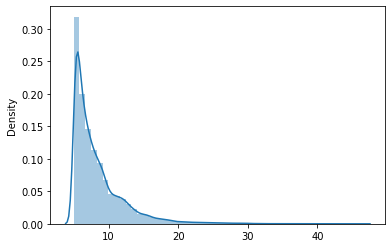

In [18]:
o = outputs[labels == label]
flato = o[:].flatten()

plt.figure()
sns.distplot(flato[flato > 5])
plt.show()

In [125]:
iout = norm_out[norm_hash == norm_hash[139]]
jout = norm_out[norm_hash == norm_hash[396]]

np.sum(np.mean((iout - jout) ** 2, axis=1))

0.40016985

In [48]:
# normalize per net (per label)
label = 1
labelmap = labels == label

norm_out = outputs.copy()

before = False

if before:
    norm_hash = hashes[labelmap]
    norm_out = norm_out[labelmap]
    norm_ref = ref_ids[labelmap]
else:
    norm_hash = hashes
    norm_ref = ref_ids

for i, net_hash in enumerate(np.unique(norm_hash)):
    hmax = norm_out[norm_hash == net_hash].max()
    
    hmean = norm_out[norm_hash == net_hash].mean()
    hstd = norm_out[norm_hash == net_hash].std()
    
    #norm_out[norm_hash == net_hash] /= hmax
    norm_out[norm_hash == net_hash] = (norm_out[norm_hash == net_hash] - hmean) / hstd
    
if not before:
    norm_hash = hashes[labelmap]
    norm_out = norm_out[labelmap]
    norm_ref = ref_ids[labelmap]

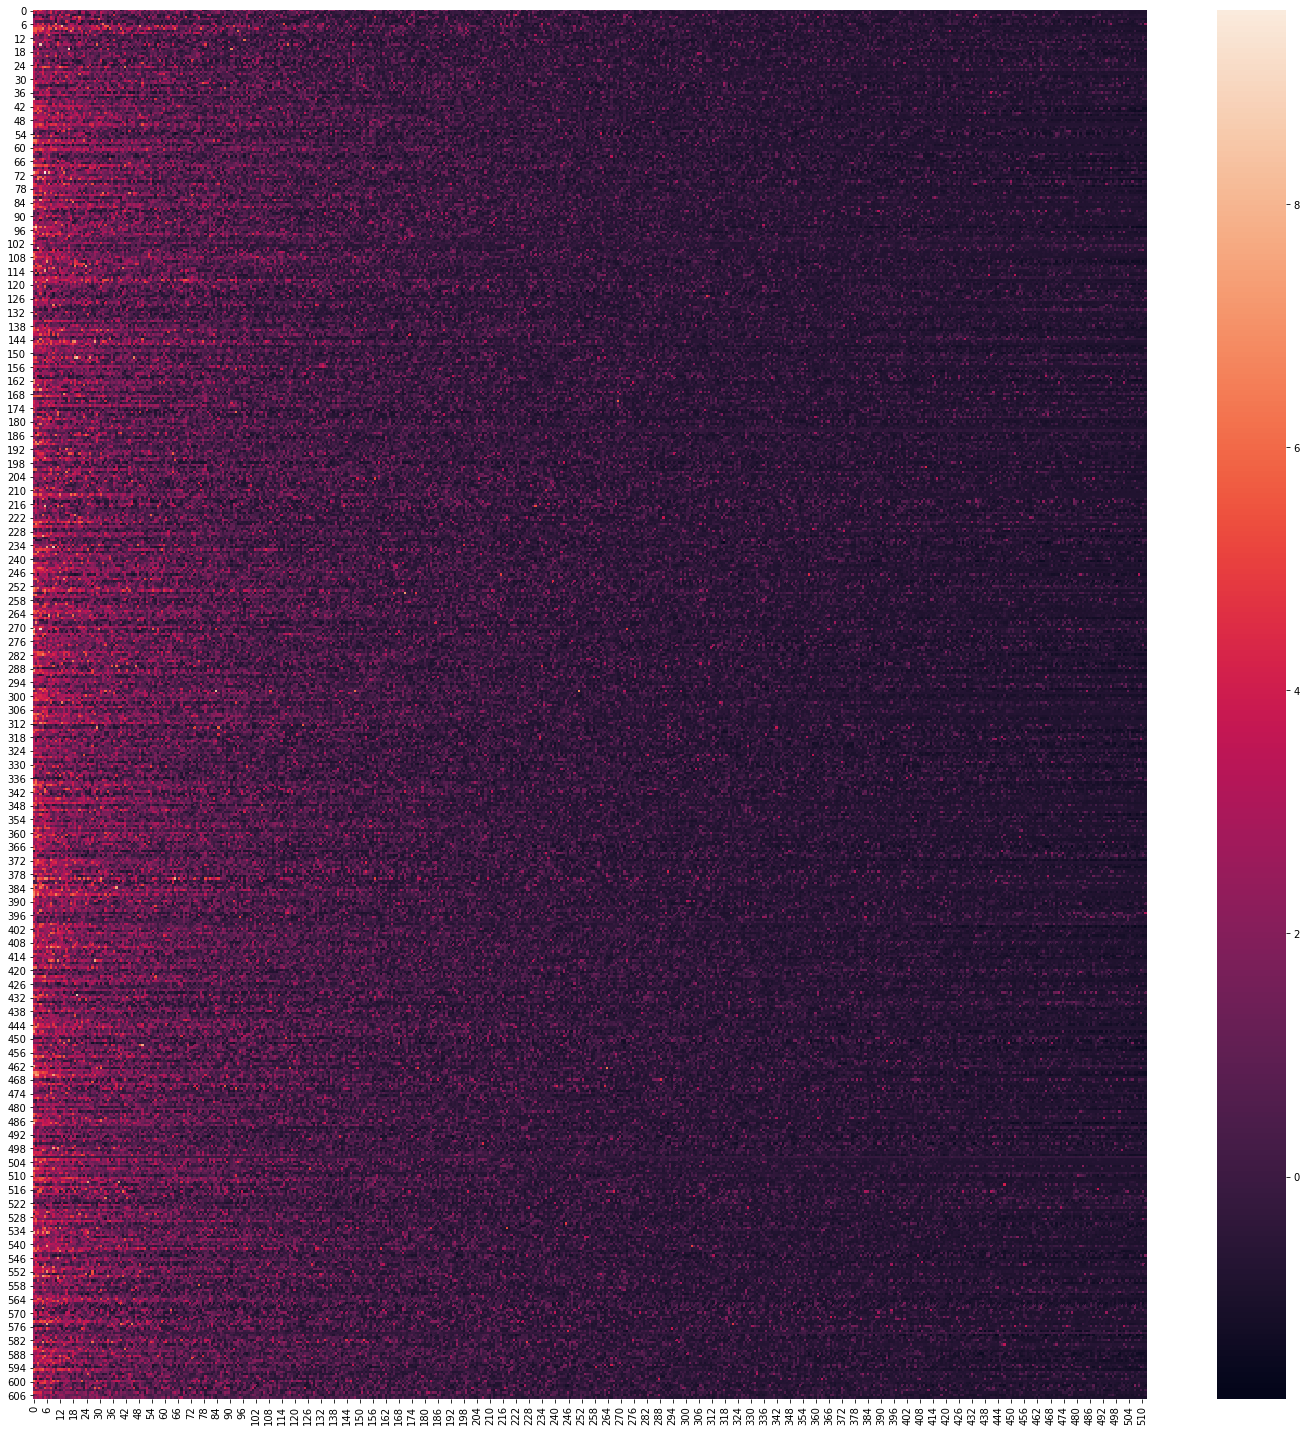

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(norm_out[norm_ref == norm_ref[0]])
plt.tight_layout()
plt.savefig(f"heatmap_all-nets_all-data_label-{label}.png")
plt.show()
plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

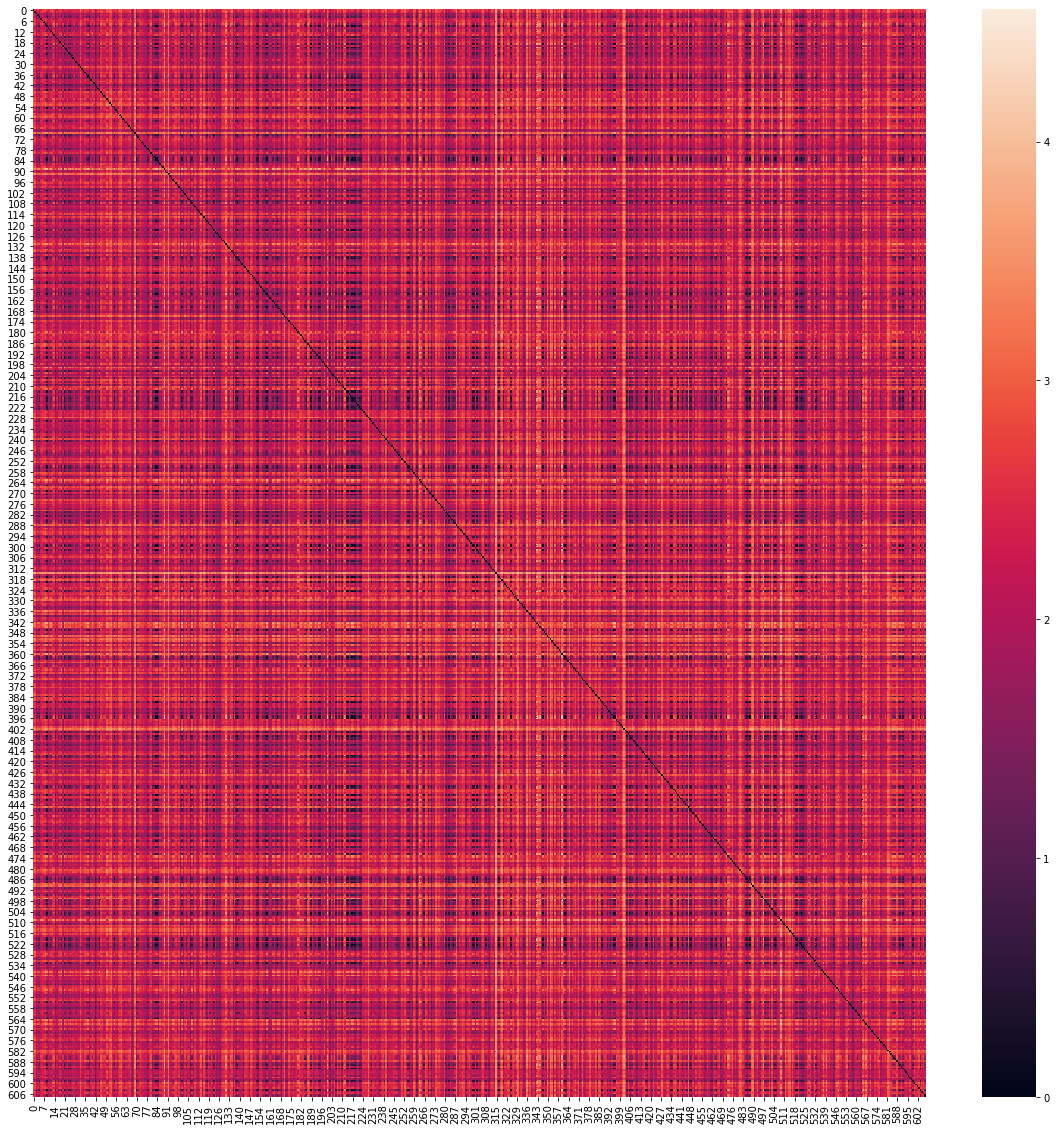

In [114]:
# ted je 1
all_hashes = np.unique(norm_hash)
size = len(all_hashes)

errors = np.zeros((size, size))

for i, ival in enumerate(all_hashes):
    print(i)
    for j, jval in enumerate(all_hashes):
        
        iout = norm_out[norm_hash == ival]
        jout = norm_out[norm_hash == jval]
        
        errors[i,j] = np.sum(np.mean((iout - jout) ** 2, axis=1))

plt.figure(figsize=(20,20))
sns.heatmap(errors)
plt.show()

In [115]:
ind = np.unravel_index(np.argsort(errors, axis=None), errors.shape)

how_many = 20

skip = 0

nskip = 0
n = 0
for i, j in zip(*ind):    
    if i == j or i > j:
        continue
    
    if nskip > 0:
        nskip = nskip + 1 if nskip < skip else 0
        continue
    else:
        nskip += 1
        
    print('---------')
    print(i, j, errors[i, j])
    
    imetrics = nb.get_metrics_from_hash(norm_hash[i])
    jmetrics = nb.get_metrics_from_hash(norm_hash[j])
    
    print('Adj:')
    print(imetrics[0]['module_adjacency'], '\n', jmetrics[0]['module_adjacency'])
    print('Ops:')
    print(imetrics[0]['module_operations'], '\n', jmetrics[0]['module_operations'])
    print('108 accuracy test, valid:')
    itrain = imetrics[1][108][1]['final_test_accuracy']
    jtrain = jmetrics[1][108][1]['final_test_accuracy']
    ival = imetrics[1][108][1]['final_validation_accuracy']
    jval = jmetrics[1][108][1]['final_validation_accuracy']
    
    print(f"{itrain} {jtrain} | {ival} {jval}")
    
    print('---------')
    
    n += 1
    if n >= how_many:
        break

---------
139 396 0.009407687932252884
Adj:
[[0 1 1 0 0 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]] 
 [[0 1 0 0 0 0 0]
 [0 0 1 0 1 1 0]
 [0 0 0 1 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
Ops:
['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output'] 
 ['input', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output']
108 accuracy test, valid:
0.9102563858032227 0.8880208134651184 | 0.9175680875778198 0.8966346383094788
---------
---------
139 417 0.010328409262001514
Adj:
[[0 1 1 0 0 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]] 
 [[0 1 0 0 0 0 0]
 [0 0 1 0 1 1 0]
 [0 0 0 1 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
Ops:
['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpo

In [74]:
np.mean(norm_out[norm_hash == norm_hash[0]], axis=1).shape

(81,)

In [99]:
nb.get_metrics_from_hash(norm_hash[i])[1][108][1]

{'halfway_training_time': 1478.9239501953125,
 'halfway_train_accuracy': 0.7168469429016113,
 'halfway_validation_accuracy': 0.6843950152397156,
 'halfway_test_accuracy': 0.6906049847602844,
 'final_training_time': 2958.14501953125,
 'final_train_accuracy': 0.9991987347602844,
 'final_validation_accuracy': 0.8966346383094788,
 'final_test_accuracy': 0.8880208134651184}

In [21]:
# fit normalizer (on original data)
#    - original data has